In [1]:
import time
import pprint
import numpy as np
from tqdm import tqdm
from sympy import Symbol
import matplotlib.pyplot as plt
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations

In [2]:
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
E3 = Symbol(u'E3', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

Δl = Symbol(u'Δl', real = True)
Δμ = Symbol(u'Δμ', real = True)

In [3]:
ham = Hamiltonian(3)
ham.addEnergies([E1, E2, E3])
ham.addCoupling(1,2,Ωl, ωl)
ham.addCoupling(0,1,Ωμ, ωμ)
ham.eqnTransform()
ham.defineZero(E2)
ham.defineStateDetuning(1,2,Δl)
ham.defineStateDetuning(0,1,Δμ)

In [4]:
Γ21 = Symbol(u'Γ12', real = True)
dis = Dissipator(3)
dis.addDecay(2,1,Γ21)

In [5]:
ham.hamiltonian

Matrix([
[                    E1,  -Ωμ*exp(1.0*I*t*ωμ)/2,                     0],
[-Ωμ*exp(-1.0*I*t*ωμ)/2,                     E2, -Ωl*exp(1.0*I*t*ωl)/2],
[                     0, -Ωl*exp(-1.0*I*t*ωl)/2,                    E3]])

In [6]:
ham.transformed

Matrix([
[1.0*E3 - 1.0*Δl - 1.0*Δμ,           -Ωμ/2,     0],
[                   -Ωμ/2, 1.0*E3 - 1.0*Δl, -Ωl/2],
[                       0,           -Ωl/2,    E3]])

In [7]:
replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0.2),
                (Ωl, 0.2),
                (E3, 0),
                (Γ21, 0.5)]

In [8]:
bloch = BlochEquations(3, dis.density_matrix, ham.transformed, dis.dissipator)

In [9]:
tstart = time.time()
sol = bloch.solveSteadyStateSymbolic([])
print(f"\n{time.time() - tstart:.3f}s to solve 3 level steady-state optical bloch equations")
print("Steady-state solution :\n")
for key in flatten([bloch.density_matrix_steady_state[i,i:] for i in \
                    range(bloch.density_matrix_steady_state.rows)]):
    try:
        print(f"{str(key):<15} : {sol[key]:.3f}")
    except:
        print(f"{str(key):<15} : {str(sol[key])}")


1.677s to solve 3 level steady-state optical bloch equations
Steady-state solution :

ρ₀₀             : (0.5*Γ12**2 + 2.0*Δl**2 + 2.0*Δμ*(2.0*Δl + Δμ) + 0.5*Ωμ**2)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₀₁             : Ωμ*(2.0*Δl + Δμ)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₀₂             : 0.5*Ωl*Ωμ/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₁₁             : 0.5*(Γ12**2 + 4.0*Δl**2 + Ωl**2 + Ωμ**2)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₁₂             : 0.5*Ωl*(-I*Γ12 + 2.0*Δl)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₂₂             : 0.5*Ωl**2/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)


In [10]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[1,1] = 1
y0 = y0.flatten()

In [11]:
replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0),
                (Ωl, 0.2),
                (E3, 0),
                (Γ21, 1)]

In [12]:
%%time
sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')

Wall time: 1.09 s


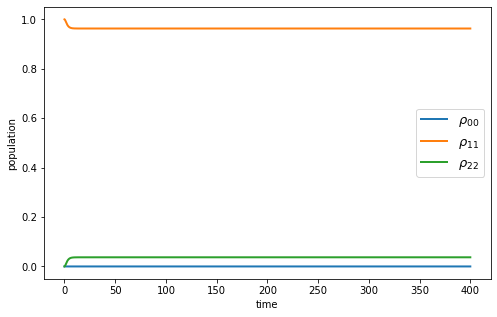

In [13]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, sol.y[0].real, label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, sol.y[4].real, label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, sol.y[8].real, label = r'$\rho_{22}$', lw = 2)
ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

In [81]:
results = {}
for Ωi in tqdm(np.linspace(0,1,5)):
    res = []
    for Δi in np.linspace(-7,7,101):
        replacements = [(Δμ, Δi),
                    (Δl, 0),
                    (Ωμ, Ωi),
                    (Ωl, 0.2),
                    (E3, 0),
                    (Γ21, 1)]
        sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')
        res.append(np.trapz(sol.y[8].real, sol.t))
    results[Ωi] = res

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:50<00:00, 82.17s/it]


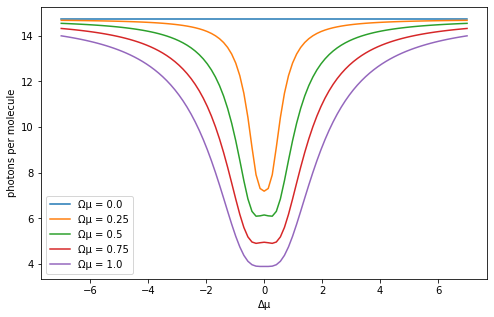

In [83]:
fig, ax = plt.subplots(figsize = (8,5))
for Ωi, res in results.items():
    ax.plot(np.linspace(-7,7,101), res, label = f'Ωμ = {Ωi}')
ax.set_xlabel('Δμ')
ax.set_ylabel('photons per molecule')
ax.legend()

In [88]:
results_Ω = []
for Ωi in tqdm(np.linspace(0,5,51)):
    replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0),
                (Ωl, Ωi),
                (E3, 0),
                (Γ21, 1)]
    sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')
    results_Ω.append(np.trapz(sol.y[8].real, sol.t))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:41<00:00,  1.23it/s]


Text(0, 0.5, 'photons per molecule')

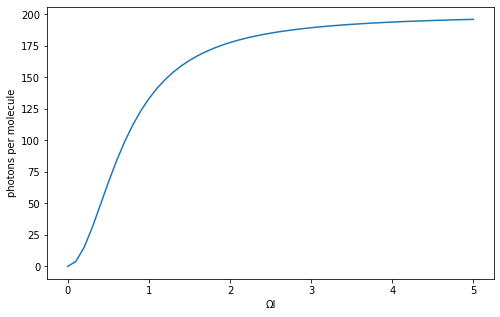

In [90]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(0,5,51), results_Ω)
ax.set_xlabel('Ωl')
ax.set_ylabel('photons per molecule')

In [149]:
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
E3 = Symbol(u'E3', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

Δl = Symbol(u'Δl', real = True)
Δμ = Symbol(u'Δμ', real = True)

In [150]:
ham = Hamiltonian(7)
ham.addEnergies([E1, E1, E1, E2, E2, E2, E3])
ham.addCoupling(4,6,Ωl, ωl)
ham.addCoupling(1,4,Ωμ, ωμ)
ham.eqnTransform()
ham.defineZero(E2)
ham.defineStateDetuning(4,6,Δl)
ham.defineStateDetuning(1,4,Δμ)

In [151]:
Γ21 = Symbol(u'Γ12', real = True)
dis = Dissipator(7)
dis.addDecay(6,3,Γ21)
dis.addDecay(6,4,Γ21)
dis.addDecay(6,5,Γ21)

In [152]:
ham.hamiltonian

Matrix([
[E1,                      0,  0,  0,                      0,  0,                     0],
[ 0,                     E1,  0,  0,  -Ωμ*exp(1.0*I*t*ωμ)/2,  0,                     0],
[ 0,                      0, E1,  0,                      0,  0,                     0],
[ 0,                      0,  0, E2,                      0,  0,                     0],
[ 0, -Ωμ*exp(-1.0*I*t*ωμ)/2,  0,  0,                     E2,  0, -Ωl*exp(1.0*I*t*ωl)/2],
[ 0,                      0,  0,  0,                      0, E2,                     0],
[ 0,                      0,  0,  0, -Ωl*exp(-1.0*I*t*ωl)/2,  0,                    E3]])

In [153]:
ham.transformed

Matrix([
[E1,                        0,  0, 0,               0, 0,     0],
[ 0, 1.0*E3 - 1.0*Δl - 1.0*Δμ,  0, 0,           -Ωμ/2, 0,     0],
[ 0,                        0, E1, 0,               0, 0,     0],
[ 0,                        0,  0, 0,               0, 0,     0],
[ 0,                    -Ωμ/2,  0, 0, 1.0*E3 - 1.0*Δl, 0, -Ωl/2],
[ 0,                        0,  0, 0,               0, 0,     0],
[ 0,                        0,  0, 0,           -Ωl/2, 0,    E3]])

In [154]:
bloch = BlochEquations(7, dis.density_matrix, ham.transformed, dis.dissipator)

In [155]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[3,3] = 1/3
y0[4,4] = 1/3
y0[5,5] = 1/3
y0 = y0.flatten()

In [156]:
replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0.2),
                (Ωl, 0.2),
                (E1, -10e3),
                (E3, 1e9),
                (Γ21, 1/3)]

In [157]:
%%time
sol = bloch.solveNumeric(replacements, [0,200], y0, method = 'BDF')

Wall time: 1.75 s


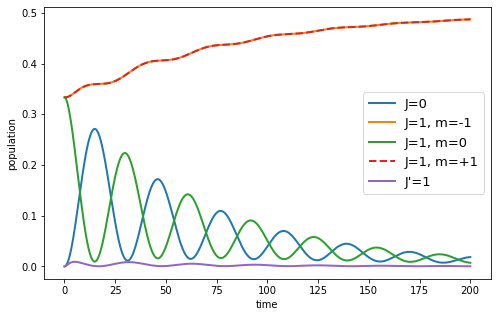

0.4611728764769568


In [158]:
r = np.einsum("iij->ij", sol.y.reshape(7,7,sol.t.size)).real
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, r[0:3].sum(axis = 0), label = r'J=0', lw = 2)
ax.plot(sol.t, r[3], label = r'J=1, m=-1', lw = 2)
ax.plot(sol.t, r[4], label = r'J=1, m=0', lw = 2)
ax.plot(sol.t, r[5], label = r'J=1, m=+1', lw = 2, ls = '--')
ax.plot(sol.t, r[6], label = r"J'=1", lw = 2)
ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

print(np.trapz(r[-1].real, sol.t))

In [159]:
results = {}
for Ωi in tqdm(np.linspace(0,1,5)):
    res = []
    for Δi in np.linspace(-7,7,101):
        replacements = [(Δμ, Δi),
                        (Δl, 0),
                        (Ωμ, Ωi),
                        (Ωl, 0.2),
                        (E1, -10e3),
                        (E3, 1e9),
                        (Γ21, 1/3)]
        sol = bloch.solveNumeric(replacements, [0,200], y0, method = 'BDF')
        res.append(np.trapz(sol.y[-1].real, sol.t))
    results[Ωi] = res

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:27<00:00, 149.43s/it]


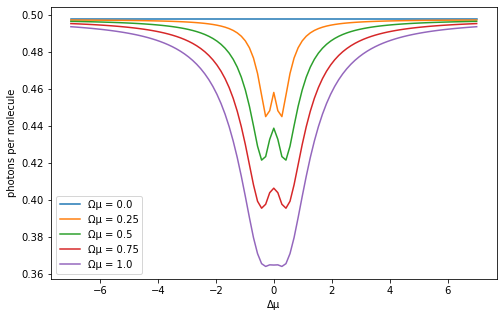

In [160]:
fig, ax = plt.subplots(figsize = (8,5))
for Ωi, res in results.items():
    ax.plot(np.linspace(-7,7,101), res, label = f'Ωμ = {Ωi}')
ax.set_xlabel('Δμ')
ax.set_ylabel('photons per molecule')
ax.legend()

In [161]:
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
E3 = Symbol(u'E3', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)

Δμ = Symbol(u'Δμ', real = True)

In [162]:
ham = Hamiltonian(3)
ham.addEnergies([E1, E2, E3])
ham.addCoupling(0,2,Ωl, ωl)
ham.addCoupling(1,2,Ωl, ωl)
ham.eqnTransform()
ham.defineZero(E2)
ham.defineStateDetuning(0,2,Δl)
ham.defineStateDetuning(1,2,Δl)

In [163]:
Γ21 = Symbol(u'Γ21', real = True)
dis = Dissipator(3)
dis.addDecay(2,0,Γ21)
dis.addDecay(2,1,Γ21)

In [164]:
ham.hamiltonian

Matrix([
[                    E1,                      0, -Ωl*exp(1.0*I*t*ωl)/2],
[                     0,                     E2, -Ωl*exp(1.0*I*t*ωl)/2],
[-Ωl*exp(-1.0*I*t*ωl)/2, -Ωl*exp(-1.0*I*t*ωl)/2,                    E3]])

In [165]:
ham.transformed

Matrix([
[1.0*E3 - 1.0*Δl,                         0, -Ωl/2],
[              0, -1.0*E1 + 1.0*E3 - 1.0*Δl, -Ωl/2],
[          -Ωl/2,                     -Ωl/2,    E3]])

In [166]:
bloch = BlochEquations(3, dis.density_matrix, ham.transformed, dis.dissipator)

In [167]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[0,0] = 0
y0[1,1] = 1
y0 = y0.flatten()

In [168]:
replacements = [(Δl, 0),
                (Ωl, 0.2),
                (E1, -0.3),
                (E3, 1e9),
                (Γ21, 1/2)]

In [169]:
%%time
sol = bloch.solveNumeric(replacements, [0,200], y0, method = 'BDF')

Wall time: 467 ms


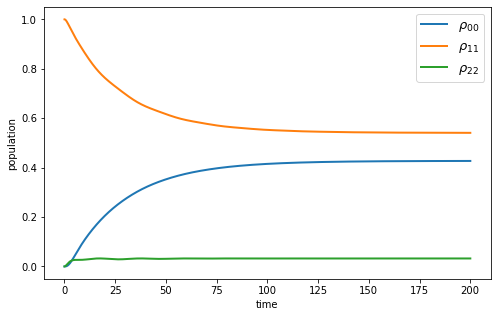

In [170]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, sol.y[0].real, label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, sol.y[4].real, label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, sol.y[8].real, label = r'$\rho_{22}$', lw = 2)
ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

In [171]:
results = {}
for Ωi in tqdm(np.linspace(0.2,1,5)):
    res = []
    for Δi in np.linspace(-1,1,101):
        replacements = [(Δl, Δi),
                        (Ωl, Ωi),
                        (E1, -0.3),
                        (E3, 0),
                        (Γ21, 1/2)]
        sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')
        res.append(np.trapz(sol.y[8].real, sol.t))
    results[Ωi] = res

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:02<00:00, 84.48s/it]


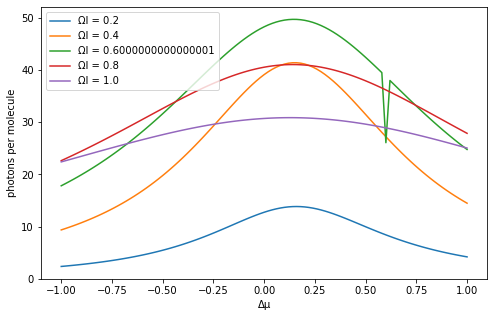

In [172]:
fig, ax = plt.subplots(figsize = (8,5))
for Ωi, res in results.items():
    ax.plot(np.linspace(-1,1,101), res, label = f'Ωl = {Ωi}')
ax.set_xlabel('Δμ')
ax.set_ylabel('photons per molecule')
ax.legend()

In [173]:
for Ωi, res in results.items():
    print(f"Ωl = {Ωi:.1f} -> {np.linspace(-1,1,101)[np.argmax(res)]:.2f}")

Ωl = 0.2 -> 0.16
Ωl = 0.4 -> 0.16
Ωl = 0.6 -> 0.14
Ωl = 0.8 -> 0.14
Ωl = 1.0 -> 0.12


In [175]:
results_Ω = []
for Ωi in tqdm(np.linspace(0,5,51)):
    replacements = [(Δl, 0),
                    (Ωl, Ωi),
                    (E1, -0.3),
                    (E3, 0),
                    (Γ21, 1/2)]
    sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')
    results_Ω.append(np.trapz(sol.y[8].real, sol.t))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:17<00:00,  1.51s/it]


Text(0, 0.5, 'photons per molecule')

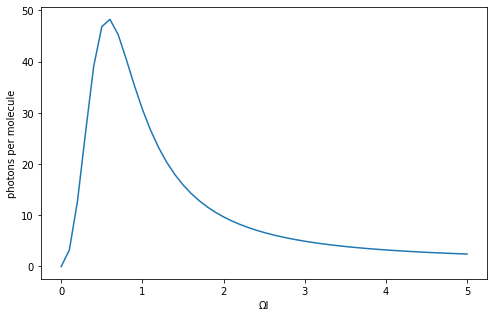

In [176]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(0,5,51), results_Ω)
ax.set_xlabel('Ωl')
ax.set_ylabel('photons per molecule')